In [135]:
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt


pd.set_option('display.mpl_style', 'default') # Make the graphs a bit prettier
plt.rcParams['figure.figsize'] = (15, 5)

In [15]:
raw_data = pd.read_csv('../data/2014_BAB_S.txt', sep=";")

In [20]:
data = raw_data
data[['Strklas', 'Strnum']] = data[['Strklas', 'Strnum']].astype(str)
data["Str"] = data['Strklas']+data['Strnum']



In [21]:
data[0:1]

,TKNR,Zst,Land,Strklas,Strnum,Datum,Wotag,Fahrtzw,Stunde,KFZ_R1,...,K_Bus_R2,LoA_R2,K_LoA_R2,Lzg_R2,K_Lzg_R2,Sat_R2,K_Sat_R2,Son_R2,K_Son_R2,Str
0,5329,4382,16,A,73,140101,3,s,1,13,...,-,0,-,1,-,1,-,0,-,A73


In [27]:
# constraint: also achsendaten at Zst

zsts_num = [9627, 9629]

zsts = pd.DataFrame({
    'zst' : pd.Series(zsts_num),
    'Strklas' : pd.Series(['A', 'A']),
    'Strnum' : pd.Series([3, 93]),
    'Ort' : pd.Series(['Schlüsselfeld', 'Fischbach am Inn']),
    'Route' : pd.Series(['kurz', 'lang'])
})

zsts



,Ort,Route,Strklas,Strnum,zst
0,Schlüsselfeld,kurz,A,3,9627
1,Fischbach am Inn,lang,A,93,9629


In [145]:
engins_birthday = 140221
standard_mask = ["Zst", "Str", "Datum", "Stunde", "Lkw_R1", "Lkw_R2"]

def slice_between( low, high, data=data):
    a = data[data["Datum"] >= low]
    b = a[a["Datum"] < high ]
    return b


def get_data_slice( data=data,
                    zst_set=set(zsts_num), 
                    mask=False, 
                    date=False):
    
    if type(zst_set) is int:
        zst_set = set([zst_set])
    data = data[data["Zst"].isin(zst_set)]

    if date: 
        if type(date) is int:
            data = data[data["Datum"]==date]
        else:
            data = data[data["Datum"].isin(date)]
    
    if mask:
        return data[mask]
    else:
        return data

In [218]:
feb = slice_between(140201,140301)
mar = slice_between(140301,140401)
apr = slice_between(140401,140501)

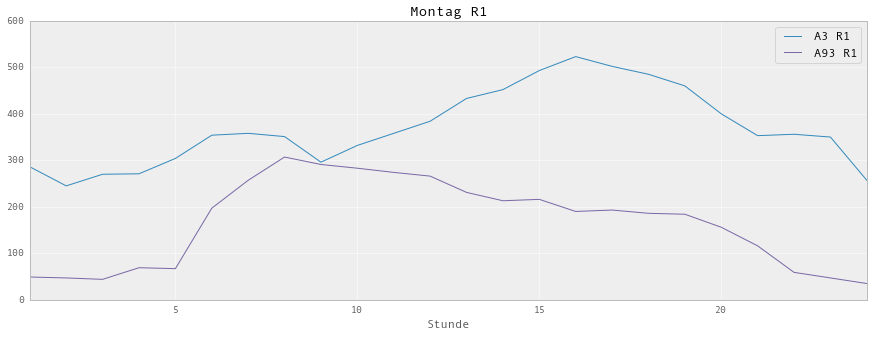

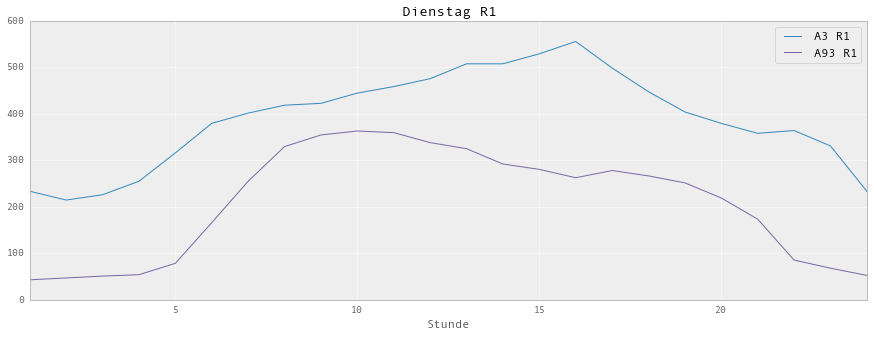

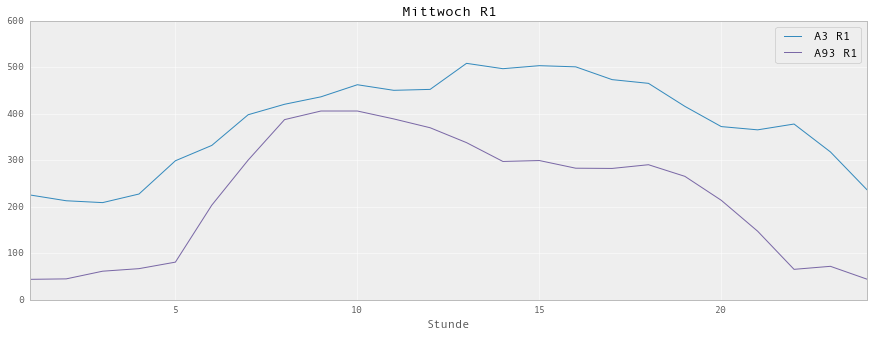

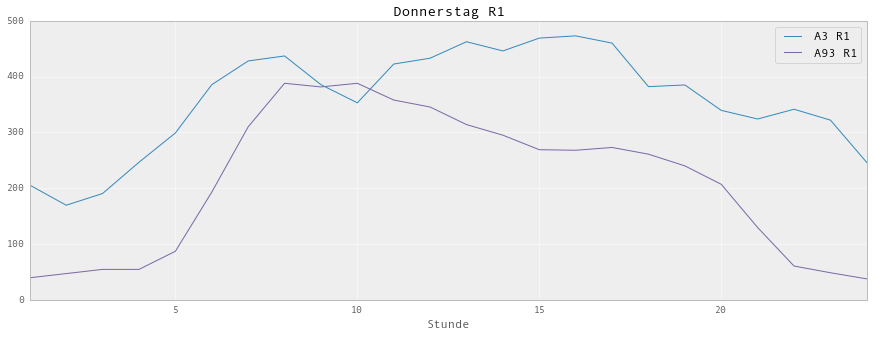

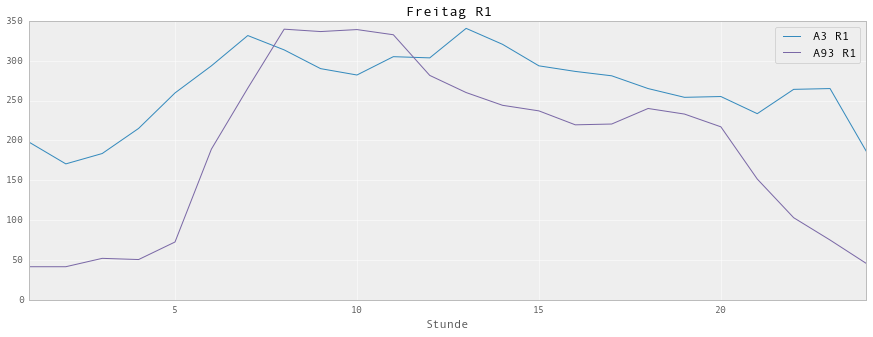

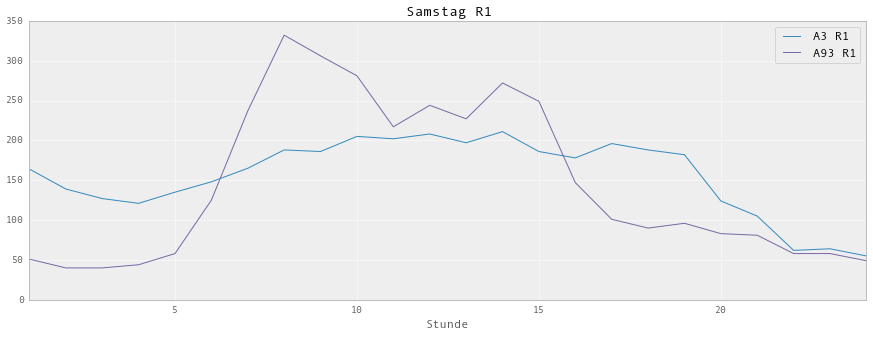

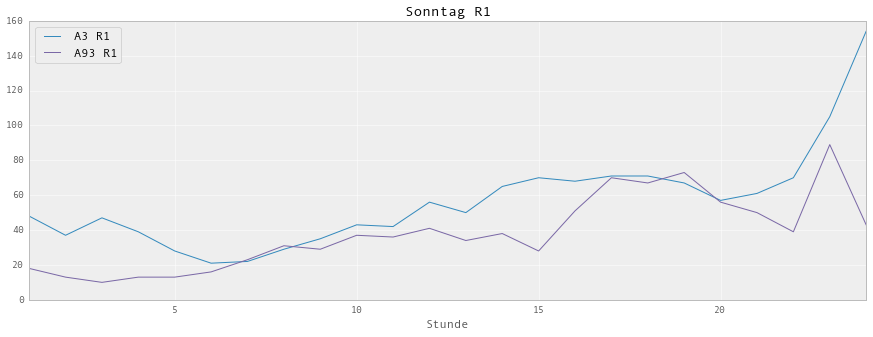

In [254]:
mask = ["Wotag","Stunde", "Lkw_R1", "Lkw_R2"]
agg_kurz = get_data_slice(zst_set=9627, mask=mask, data=mar )
agg_lang = get_data_slice(zst_set=9629, mask=mask, data=mar )


days = ["Montag", "Dienstag", "Mittwoch", "Donnerstag", "Freitag", "Samstag", "Sonntag"]

for i in range(len(days)):
    day_kurz = agg_kurz[ agg_kurz["Wotag"] == i+1 ].groupby("Stunde").median()[["Lkw_R1", "Lkw_R2"]]
    day_lang = agg_lang[ agg_lang["Wotag"] == i+1 ].groupby("Stunde").median()[["Lkw_R1", "Lkw_R2"]]
    day = pd.concat( [ day_kurz["Lkw_R1"], day_kurz["Lkw_R2"], day_lang["Lkw_R1"], day_lang["Lkw_R2"]], axis=1)
    day.columns = ["A3 R1", "A3 R2", "A93 R1", "A93 R2"]
    fig = day[["A3 R1","A93 R1"]].plot(title=days[i]+" R1" ).get_figure()
    fig.savefig("vm_maerz_tag"+str(i)+"s_lkws_pro_stunde_R1.png")
    # day[["kurz R2","lang R2"]].plot(title=days[i]+" R2" ) # there is not interesting switch here


Lkw_R1    6056
Lkw_R2    8800
Name: 140221, dtype: int64
Lkw_R1    4358
Lkw_R2    3956
Name: 140221, dtype: int64


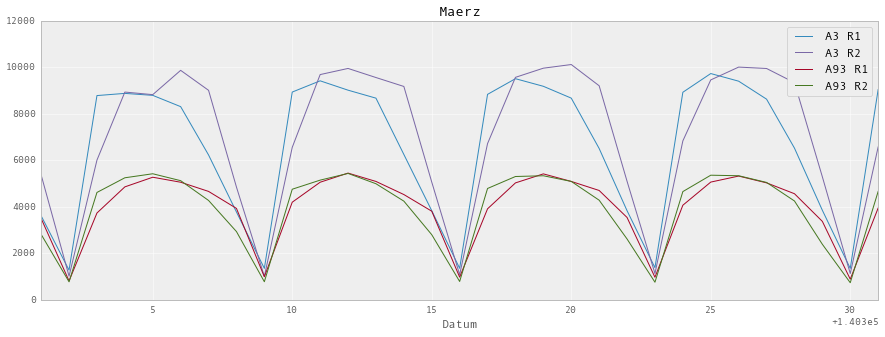

In [255]:
# aggregate: sum lkws in one directions per day

mask = ["Datum","Lkw_R1", "Lkw_R2"]
agg_kurz = get_data_slice(zst_set=9627, mask=mask ).groupby("Datum").sum()
print agg_kurz.ix[engins_birthday]

agg_lang = get_data_slice(zst_set=9629, mask=mask ).groupby("Datum").sum()
print agg_lang.ix[engins_birthday]


r_both = pd.concat( [ agg_kurz["Lkw_R1"], agg_kurz["Lkw_R2"], agg_lang["Lkw_R1"], agg_lang["Lkw_R2"]], axis=1)
r_both.columns = [ "kurz R1", "kurz R2", "lang R1", "lang R2" ]
r_both["Datum"] = r_both.index

mask = [ "kurz R1", "kurz R2", "lang R1", "lang R2" ]
df = slice_between(140301,140401, r_both )[mask]
df.columns = ["A3 R1", "A3 R2", "A93 R1", "A93 R2"]

fig = df.plot(title="Maerz").get_figure()
fig.savefig('vm_maerz_lkws_pro_tag.png')

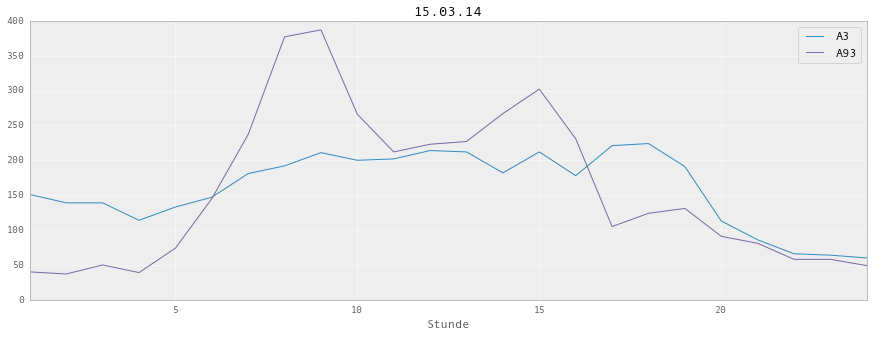

In [253]:
# 15.03.2014 (Samstag) LKWs pro Stunde

mask = ["Stunde", "Lkw_R1"]
kurz = get_data_slice(zst_set=9627, mask=mask, data=mar, date=140315 ).set_index("Stunde")
lang = get_data_slice(zst_set=9629, mask=mask, data=mar, date=140315 ).set_index("Stunde")

both = pd.concat([kurz["Lkw_R1"], lang["Lkw_R1"]], axis=1)
both.columns = ['A3', 'A93']

both.plot(title="15.03.14")
